In [92]:
import numpy as np
import pandas as pd
import pickle
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, random_split
import os
from sklearn.metrics import confusion_matrix,f1_score
import matplotlib.pyplot as plt
import seaborn as sn
np.random.seed(1)

Dense Layer

In [93]:
class Dense:
    def __init__(self, input_dim, output_dim):
        # Xavier initialization, input_dim+output_dim/input_dim
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2 / (input_dim+output_dim))
        self.bias = np.zeros((1, output_dim))
        self.grads = {'weights': np.zeros_like(self.weights), 'bias': np.zeros_like(self.bias)}
        
    def forward(self, X):
        # print(f'{self.__class__.__name__}')
        # print(X.shape)
        self.input = X
        # Wx+b
        self.output = np.dot(X, self.weights) + self.bias
        return self.output
    
    def backward(self, dL_doutput):
        # Gradients
        dL_dinput = np.dot(dL_doutput, self.weights.T)
        dL_dweights = np.dot(self.input.T, dL_doutput)
        dL_dbias = np.sum(dL_doutput, axis=0, keepdims=True)
        # Update weights and biases
        self.grads['weights'] = dL_dweights
        self.grads['bias'] = dL_dbias
        return dL_dinput

Normalization

In [94]:
class BatchNormalization:
    def __init__(self, input_dim, epsilon=1e-5, momentum=0.9):
        self.input_dim=input_dim
        self.epsilon = epsilon
        self.momentum = momentum
        # scale parameter
        self.gamma = np.ones((1, self.input_dim))
        # shift parameter
        self.beta = np.zeros((1, self.input_dim))
        self.moving_mean = np.zeros((1, self.input_dim))
        self.moving_var = np.ones((1, self.input_dim))

    def forward(self, X, training=True):
        # print(f'{self.__class__.__name__}')
        # print(X.shape)
        if training:
            # page 296, something about len(X.shape)
            self.mean = np.mean(X, axis=0, keepdims=True)
            self.var = np.var(X, axis=0, keepdims=True)
            self.X_centered = X - self.mean
            self.std = np.sqrt(self.var + self.epsilon)
            self.X_norm=self.X_centered/self.std

            # Update running statistics
            self.moving_mean = self.momentum * self.moving_mean + (1 - self.momentum) * self.mean
            self.moving_var = self.momentum * self.moving_var + (1 - self.momentum) * self.var
        else:
            self.X_norm = (X - self.moving_mean) / np.sqrt(self.moving_var + self.epsilon)
        
        return self.gamma * self.X_norm + self.beta
    # confused about the backward propagation
    def backward(self, dL_doutput):
        m = dL_doutput.shape[0]
        dL_dgamma = np.sum(dL_doutput * self.X_norm, axis=0, keepdims=True)
        dL_dbeta = np.sum(dL_doutput, axis=0, keepdims=True)
        dL_dX_norm = dL_doutput * self.gamma
        dL_dvar = np.sum(dL_dX_norm * self.X_centered * -0.5 / (self.std ** 3), axis=0, keepdims=True)
        dL_dmean = np.sum(dL_dX_norm * -1 / self.std, axis=0, keepdims=True) + dL_dvar * np.mean(-2 * self.X_centered, axis=0, keepdims=True)
        
        dL_dinput = dL_dX_norm / self.std + dL_dvar * 2 * self.X_centered / m + dL_dmean / m
        
        return dL_dinput


Activation

In [95]:
class ReLU:
    def forward(self, X):
        # print(f'{self.__class__.__name__}')
        # print(X.shape)
        self.output = np.maximum(0, X)
        return self.output
    
    def backward(self, dL_doutput):
        return dL_doutput * (self.output > 0)


Regularization

In [96]:
# Apply after activation function, page 177
class Dropout:

    def __init__(self, dropout):
        self.dropout = dropout


    def forward(self, X, training=True):
        # print(f'{self.__class__.__name__}')
        # print(X.shape)
        if training:
            assert 0 <= self.dropout <= 1
            # In this case, all elements are dropped out
            if self.dropout == 1:
                return np.zeros_like(X)
            # In this case, all elements are kept
            if self.dropout == 0:
                return X
            self.mask = np.random.uniform(0, 1, X.shape) > self.dropout
            # self.mask = np.random.binomial(1, 1 - self.dropout, size=X.shape)

            return X * self.mask.astype(np.float32)

        return X

    # confused about the back propagation
    def backward(self, dL_doutput):
        return dL_doutput * self.mask

Optimization

In [97]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.005, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        # momentum
        self.mw = None
        self.mb = None
        # second momentum
        self.vw = None
        self.vb = None
        # time step counter
        self.t = 0
        
    def update(self, layer):
        self.t += 1
        if self.mw is None:
            self.mw = np.zeros_like(layer.weights)
            self.mb = np.zeros_like(layer.bias)
            self.vw = np.zeros_like(layer.weights)
            self.vb = np.zeros_like(layer.bias)
        self.mw = self.beta1 * self.mw + (1 - self.beta1) * layer.grads['weights']
        self.mb = self.beta1 * self.mb + (1 - self.beta1) * layer.grads['bias']
        self.vw = self.beta2 * self.vw + (1 - self.beta2) * np.power(layer.grads['weights'], 2)
        self.vb = self.beta2 * self.vb + (1 - self.beta2) * np.power(layer.grads['bias'], 2)
        mw_hat = self.mw / (1 - np.power(self.beta1, self.t))
        mb_hat = self.mb / (1 - np.power(self.beta1, self.t))
        vw_hat = self.vw / (1 - np.power(self.beta2, self.t))
        vb_hat = self.vb / (1 - np.power(self.beta2, self.t))
        layer.weights -= self.learning_rate * mw_hat / (np.sqrt(vw_hat) + self.epsilon)
        layer.bias -= self.learning_rate * mb_hat / (np.sqrt(vb_hat) + self.epsilon)
        


Regression

In [98]:
class Softmax:
    def forward(self, X):
        # print(f'{self.__class__.__name__}')
        # print(X.shape)
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output
    
    def backward(self, dL_doutput):
        # In multi-class classification, the gradient of cross-entropy with softmax simplifies the backward pass.
        return dL_doutput


Feed-Forward Neural Network implementation

In [99]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X, training=True):

        # print('start')
        # print(f'{self.__class__.__name__}')
        # print(X.shape)
        for layer in self.layers:
            if isinstance(layer, Dropout):
                X = layer.forward(X, training)
            else:
                X = layer.forward(X)
        return X

    def backward(self, dL_doutput,optimizer):
        for layer in reversed(self.layers):
            dL_doutput = layer.backward(dL_doutput)
            if isinstance(layer,Dense):
                optimizer=AdamOptimizer(0.005)
                # params_and_grads = self.get_params_and_grads(layer)
                optimizer.update(layer)

    def plot_graphs(self,index,learning_rate,train_loss,validation_loss,training_acc,validation_acc,val_f1_scores,axs,fig):
        # show both training and validation loss in the same graph wrt epoch
        if index!=0:
            axs[0, 0].set_title(F"Learning rate={learning_rate},model={index}")
        axs[0, 0].plot(train_loss, label='Train Loss')
        axs[0, 0].plot(validation_loss, label='Val Loss')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].legend()
        # plt.savefig(f"loss_model{index}_lr{learning_rate}.png")
        # axs[0, 0].show()

        if index!=0:
            axs[0, 1].set_title(F"Learning rate={learning_rate},model={index}")
        axs[0, 1].plot(training_acc, label='Train Accuracy')
        axs[0, 1].plot(validation_acc, label='Validation Accuracy')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Accuracy')
        axs[0, 1].legend()
        # plt.savefig(f"accuracy_model{index}_lr{learning_rate}.png")
        # axs[0, 1].show()

        if index!=0:
            axs[1, 0].set_title(F"Learning rate={learning_rate},model={index}")
        axs[1, 0].plot(val_f1_scores, label='Val F1 Score')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('F1 Score')
        axs[1, 0].legend()
        # plt.savefig(f"valf1_model{index}_lr{learning_rate}.png")
        # axs[1, 0].show()

    def plot_cm(self,best_y_val_true,best_y_val_pred,axs,fig):
        cm = confusion_matrix(best_y_val_true, best_y_val_pred)
        df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                    columns = [i for i in "0123456789"])
        # plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True, ax=axs[1, 1],fmt='g')
        # plt.show()

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size,learning_rate,index=0):
        # optimizer = AdamOptimizer(learning_rate)
        train_loss = []
        validation_loss = []
        training_acc = []
        validation_acc = []
        val_f1_scores = []
        epsilon = 1e-11
        
        best_y_val_pred = [] 
        best_y_val_true = [] 
        best_f1=0.0
        for epoch in range(epochs):
            correct_train = 0
            correct_val = 0
            training_loss = 0.0
            val_loss = 0.0
            y_val_pred = [] 
            y_val_true = [] 
            # Divide into batches
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                
                # Forward pass
                predictions = self.forward(X_batch, training=True)
                
                predictions = np.clip(predictions, epsilon, 1. - epsilon)
                loss = -np.mean(np.sum(y_batch * np.log(predictions), axis=1))  # Cross-entropy loss
                # calculate loss
                training_loss += loss
                # calculate accuracy
                correct_train += np.sum(np.argmax(predictions, axis=1) == np.argmax(y_batch, axis=1))
                # Backward pass
                dL_doutput = predictions - y_batch  # Gradient of cross-entropy
                optimizer = AdamOptimizer(learning_rate)
                self.backward(dL_doutput,optimizer)
                
                # Get params and gradients, update using Adam optimizer
                # params_and_grads = self.get_params_and_grads()
                # optimizer.update({k: params_and_grads[k] for k in params_and_grads if 'grads' not in k},
                #                  {k.split('grads_')[0]+k.split('grads_')[1]: params_and_grads[k] for k in params_and_grads if 'grads' in k})
                # if epoch==epochs-1 and i+batch_size>=len(X_train):
                #     self.save_model(filepath)
            # training_loss /= len(X_train)
            train_loss.append(training_loss/(len(X_train)/batch_size))
            training_acc.append(correct_train / len(X_train))
            # calculate validation loss
            for i in range(0, len(X_val), batch_size):
                X_val_batch = X_val[i:i+batch_size]
                y_val_batch = y_val[i:i+batch_size]
                val_predictions = self.predict(X_val_batch)
                val_predictions = np.clip(val_predictions, epsilon, 1. - epsilon)
                loss = -np.mean(np.sum(y_val_batch * np.log(val_predictions), axis=1))
                val_loss+=loss
                predicted_classes = np.argmax(val_predictions, axis=1) 
                true_classes = np.argmax(y_val_batch, axis=1) 
                correct_val += np.sum(predicted_classes == true_classes) 
                y_val_pred.extend(predicted_classes) 
                y_val_true.extend(true_classes) 
            validation_loss.append(val_loss/(len(X_val)/batch_size))
            validation_acc.append(correct_val/len(X_val))
            # calculate f1
            f1 = f1_score(y_val_true, y_val_pred, average='macro') 
            if f1>best_f1:
                best_f1=f1
                best_y_val_pred=y_val_pred
                best_y_val_true=y_val_true
            val_f1_scores.append(f1)
        # plot graphs
        fig, axs = plt.subplots(2, 2, figsize=(14, 12))
        self.plot_graphs(index,learning_rate,train_loss,validation_loss,training_acc,validation_acc,val_f1_scores,axs,fig)
        # confusion matrix
        # val_predictions = self.predict(X_val)
        self.plot_cm(best_y_val_true,best_y_val_pred,axs,fig)
        plt.tight_layout()
        plt.show()
    
    def predict(self, X):
        return self.forward(X, training=False)
    
    def evaluate(self,X_test,y_test):
        prediction = self.predict(X_test)
        cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(prediction, axis=1))
        # y_pred=[[1 if prob == max(row) else 0 for prob in row] for row in prediction]
        # y_pred=np.array(y_pred)
        # accuracy = np.mean(y_pred == y_test)
        correct_predictions = np.trace(cm)
        # total_instances = np.sum(cm)
        accuracy = correct_predictions / len(y_test)
        # loss = -np.mean(np.sum(y_test * np.log(prediction + 1e-8), axis=1))  # Cross-entropy loss
        print(f"Accuracy: {accuracy * 100:.2f}%")
        # print(f"Loss: {loss}")
        # y_test=[[j if k == 1 else 0 for j,k in enumerate(i)] for i in y_test]
        # y_test=[max(i) for i in y_test]
        # y_pred=[[j if k == 1 else 0 for j,k in enumerate(i)] for i in y_pred]
        # y_pred=[max(i) for i in y_pred]
        TP = []
        FP = []
        FN = []
        TN = []
        num_classes = cm.shape[0]
        for i in range(num_classes):
            TP_i = cm[i, i]
            FP_i = cm[:, i].sum() - TP_i
            FN_i = cm[i, :].sum() - TP_i
            TN_i = cm.sum() - (TP_i + FP_i + FN_i)
            
            TP.append(TP_i)
            FP.append(FP_i)
            FN.append(FN_i)
            TN.append(TN_i)

        specificities = []
        precisions = []
        recalls = []
        f1_scores = []

        for i in range(len(TP)):
            specificity = TN[i] / (TN[i] + FP[i]) if (TN[i] + FP[i]) > 0 else 0
            precision = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0
            recall = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0
            f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            specificities.append(specificity)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)

        # avg_specificity = sum(specificities) / len(specificities)
        # avg_precision = sum(precisions) / len(precisions)
        # avg_recall = sum(recalls) / len(recalls)
        # avg_f1_score = sum(f1_scores) / len(f1_scores)

        # print("Average Specificity:", avg_specificity)
        # print("Average Precision:", avg_precision)
        # print("Average Recall:", avg_recall)
        # print("Average F1 Score:", avg_f1_score)

        return accuracy,max(f1_scores)

    def save_model(self, filepath):
        params = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Dense):
                params[f"layer_{i}_weights"] = layer.weights
                params[f"layer_{i}_bias"] = layer.bias
            # if isinstance(layer, BatchNormalization):
            #     params[f"layer_{i}_gamma"] = layer.gamma
            #     params[f"layer_{i}_beta"] = layer.beta
        with open(filepath, 'wb') as f:
            pickle.dump(params, f)

    def load_model(self,filepath):
        with open(filepath, 'rb') as f:
            params = pickle.load(f)
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Dense):
                layer.weights = params[f"layer_{i}_weights"]
                layer.bias = params[f"layer_{i}_bias"]
            # if isinstance(layer, BatchNormalization):
            #     layer.gamma = params[f"layer_{i}_gamma"]
            #     layer.beta = params[f"layer_{i}_beta"]


Data loading

In [100]:
def load_data():
    transform=transforms.ToTensor()
    train_dataset=datasets.FashionMNIST(root='./data',train=True,transform=transform,download=True)
    test_dataset=datasets.FashionMNIST(root='./data',train=False,transform=transform,download=True)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    X_train, y_train = next(iter(train_loader))
    X_train= X_train / 255.0
    X_train = X_train.reshape(-1, 28*28).numpy()  # Flatten the images
    y_train=np.eye(10)[y_train]

    X_val, y_val = next(iter(val_loader))
    X_val= X_val / 255.0
    X_val = X_val.reshape(-1, 28*28).numpy()  # Flatten the images
    y_val=np.eye(10)[y_val]

    X_test, y_test = next(iter(test_loader))
    X_test= X_test / 255.0
    X_test = X_test.reshape(-1, 28*28).numpy()
    y_test=np.eye(10)[y_test]

    # print(y_val[:10])
    # y_val=[[j if k == 1 else 0 for j,k in enumerate(i)] for i in y_val]
    # y_val=[max(i) for i in y_val]
    # print(y_val[:10])
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_val shape:", X_val.shape)
    print("y_val shape:", y_val.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test

Data cleaning

In [101]:
def save_model(model, filepath):
    # params = {}
    # for i, layer in enumerate(self.layers):
    #     if isinstance(layer, Dense):
    #         params[f"layer_{i}_weights"] = layer.weights
    #         params[f"layer_{i}_bias"] = layer.bias
        # if isinstance(layer, BatchNormalization):
        #     params[f"layer_{i}_gamma"] = layer.gamma
        #     params[f"layer_{i}_beta"] = layer.beta
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)

def load_model(filepath):
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    return model
    # for i, layer in enumerate(self.layers):
    #     if isinstance(layer, Dense):
    #         layer.weights = params[f"layer_{i}_weights"]
    #         layer.bias = params[f"layer_{i}_bias"]
        # if isinstance(layer, BatchNormalization):
        #     layer.gamma = params[f"layer_{i}_gamma"]
        #     layer.beta = params[f"layer_{i}_beta"]

Building the architecture

In [102]:
# Define network architecture
# network = NeuralNetwork([
#     Layer(input_dim=28*28, output_dim=128),
#     BatchNormalization(input_dim=128),
#     ReLU(),
#     Dropout(dropout=0.2),
#     Layer(input_dim=128, output_dim=10),
#     Softmax()
# ])

# here Layer(784, 128) means input layer has 784 neurons and hidden layer has 128 neurons
# Layer(128, 10) that hidden layer with 128 layers plus output layer with 10 neurons
X_train, y_train, X_val, y_val, X_test, y_test=load_data()
folder_path = './pickle/'
filename = 'weights.pkl'
os.makedirs(folder_path, exist_ok=True)
filepath = os.path.join(folder_path, filename)
# network.train(X_train,y_train,X_val,y_val,10,64,0.005)
# network.save_model(filepath)

X_train shape: (48000, 784)
y_train shape: (48000, 10)
X_val shape: (12000, 784)
y_val shape: (12000, 10)
X_test shape: (10000, 784)
y_test shape: (10000, 10)


Validation block

Model 1 with learning rate = 0.005


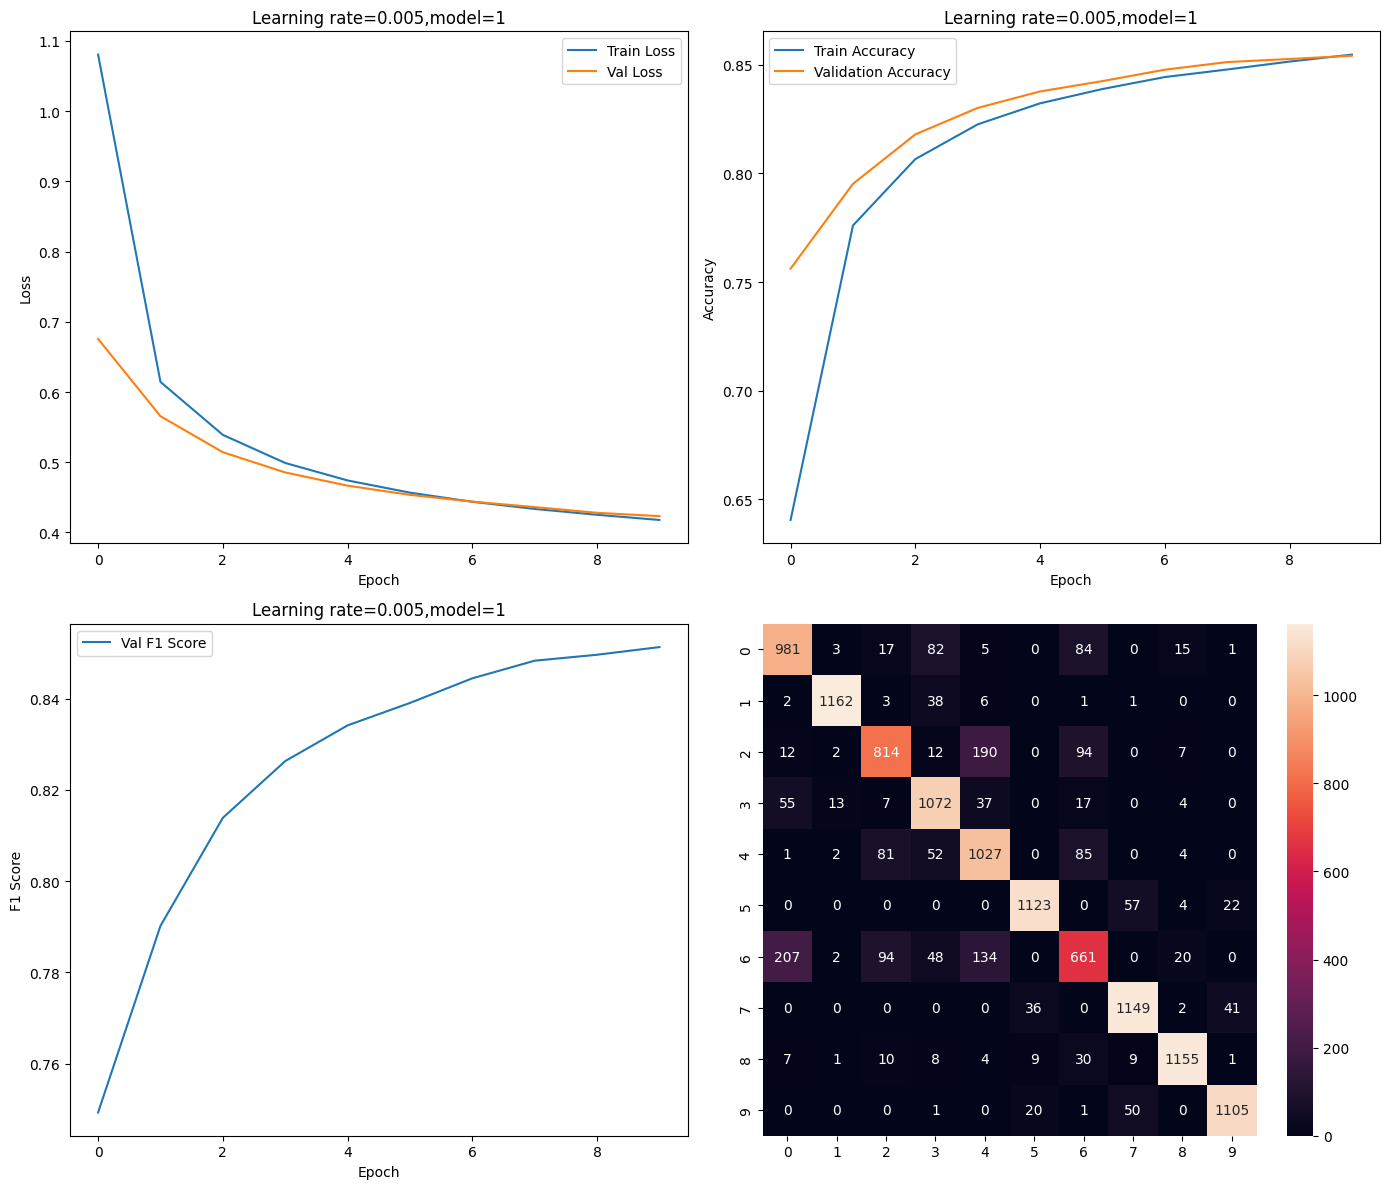

Accuracy: 85.41%
Model 2 with learning rate = 0.005


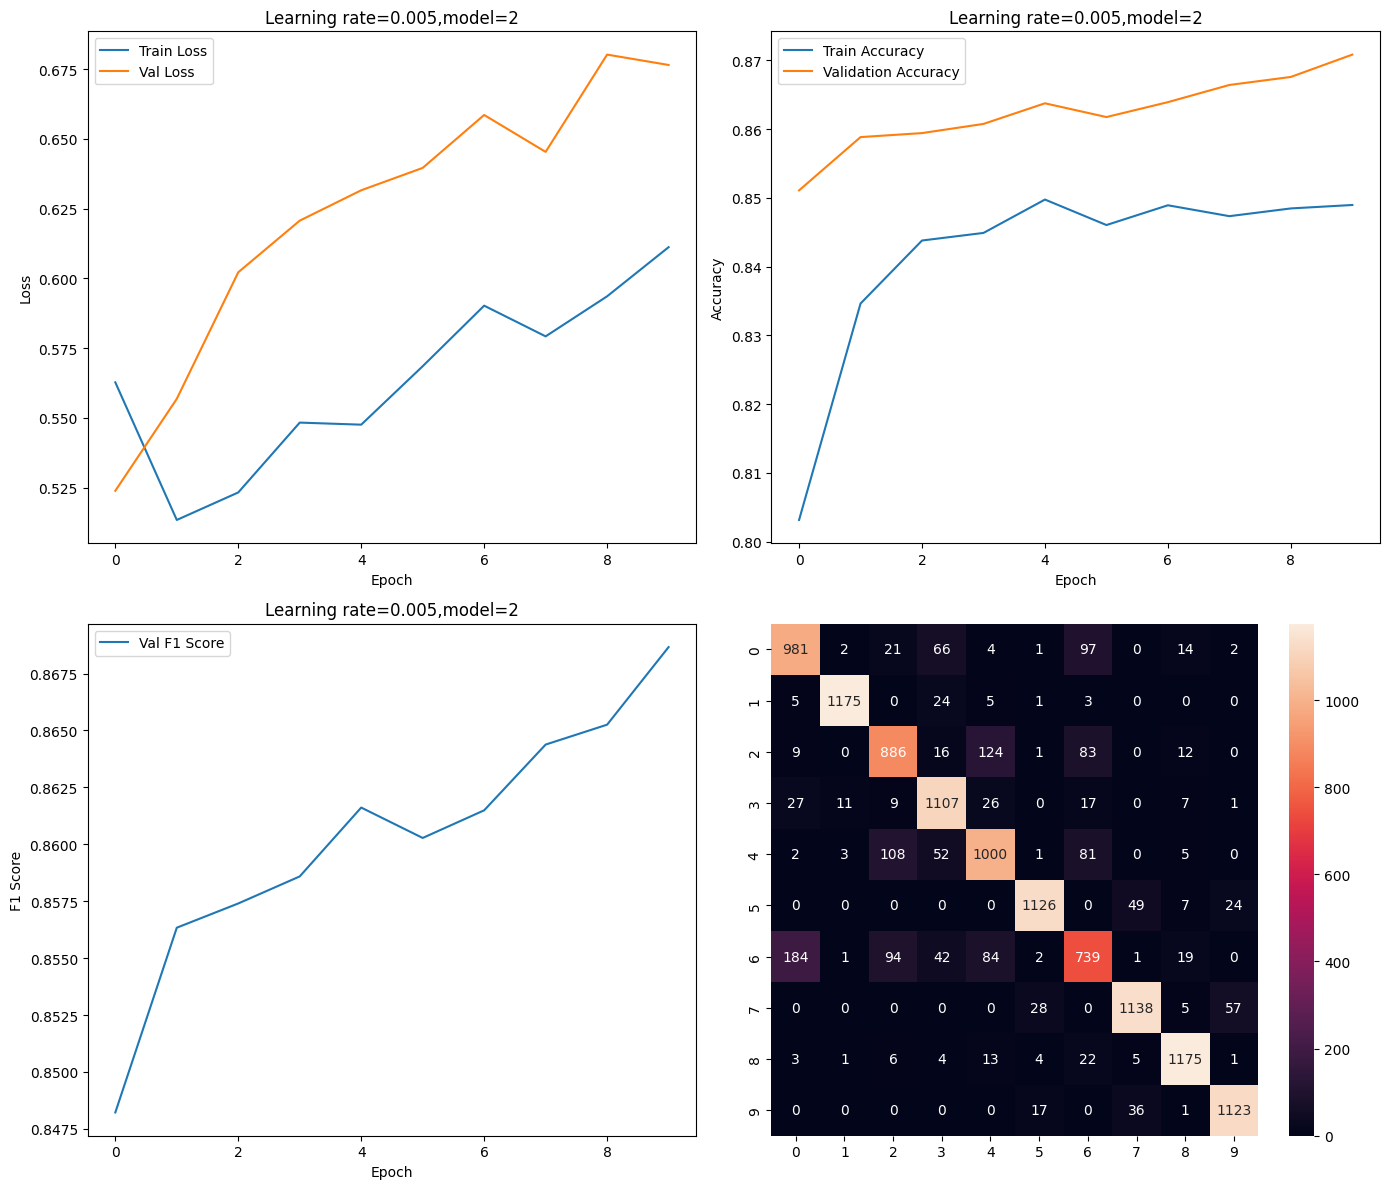

Accuracy: 87.62%
Model 3 with learning rate = 0.005


In [ ]:
networks = [
        NeuralNetwork([
            Dense(28 * 28, 128),
            ReLU(),
            Dense(128, 10),
            Softmax()
        ]),
        NeuralNetwork([
            Dense(28 * 28, 256),
            BatchNormalization(256),
            ReLU(),
            Dropout(0.3),
            Dense(256, 128),
            BatchNormalization(128),
            ReLU(),
            Dropout(0.3),
            Dense(128, 10),
            Softmax()
        ]),
        NeuralNetwork([
            Dense(28 * 28, 512),
            BatchNormalization(512),
            ReLU(),
            Dropout(0.4),
            Dense(512, 256),
            BatchNormalization(256),
            ReLU(),
            Dropout(0.4),
            Dense(256, 128),
            BatchNormalization(128),
            ReLU(),
            Dropout(0.4),
            Dense(128, 10),
            Softmax()
        ])
    ]
# The hyperparameter we'll change is the number of neurons in the hidden layer, ranging from n_neurons[0] to n_neurons[-1]
best_model=None
best_f1=0.0
best_lr=0.0
best_model_idx=-1
learning_rates = [5e-3, 1e-3, 5e-4, 1e-4]
# learning_rates = [8e-3]
for learning_rate in learning_rates:
    for index, model in enumerate(networks):
        # Train
        print(f"Model {index+1} with learning rate = {learning_rate}")
        model.train(X_train, y_train,X_val,y_val,10,128,learning_rate,index+1)

        current_accuracy,current_f1 = model.evaluate(X_val, y_val)
        
        if current_f1>best_f1:
            best_f1=current_f1
            best_model=model
            best_lr=learning_rate
            best_model_idx=index+1
# print(f"Best model: model {best_model_idx} with learning rate = {best_lr}")
# # save_model(best_model,filepath)
# best_model.save_model(filepath)


Testing block

In [ ]:
print(f"Best model: model {best_model_idx} with learning rate = {best_lr}")
best_model.save_model(filepath)
best_model.evaluate(X_test,y_test)

Best model: model 2 with learning rate = 0.005
Accuracy: 86.49%


(0.8649, 0.9717171717171716)

In [ ]:
# network=load_model(filepath)
network=NeuralNetwork([
            Dense(28 * 28, 256),
            BatchNormalization(256),
            ReLU(),
            Dropout(0.3),
            Dense(256, 128),
            BatchNormalization(128),
            ReLU(),
            Dropout(0.3),
            Dense(128, 10),
            Softmax()
        ])
network.load_model(filepath)
network.evaluate(X_test,y_test)

Accuracy: 86.49%


(0.8649, 0.9717171717171716)